In [ ]:

https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/

In [13]:
# Import Dependencies
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
# Hyper-parameters
output_dir = 'model_output/conv'
epochs = 4
batch_size = 128
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2
n_dense = 256
dropout = 0.2
n_conv = 256
k_conv = 3

In [14]:
# Load and Preprocess the Data
(X_train, y_train), (X_valid, y_valid) =imdb.load_data(num_words=n_unique_words)
X_train = pad_sequences(X_train, maxlen=max_review_length, 
    padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, 
    padding=pad_type, truncating=trunc_type, value=0)

In [15]:
# Design the Convolution Network Architecture
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
#Check the Model Summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
#Create Model Checkpoint

modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#Compile the Model

model.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=['accuracy'])

#Train the Model

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
    verbose=1, validation_split=.20,
    callbacks=[modelcheckpoint])

#Load the Best Weights and Predict

# In my case it was the fourth one: 'weights.04.hdf5'
model.load_weights(output_dir+'/weights.04.hdf5')
y_hat = model.predict_proba(X_valid)

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
20000/20000 [==============================] - 96s 5ms/sample - loss: 0.5395 - accuracy: 0.6905 - val_loss: 0.3431 - val_accuracy: 0.8480
Epoch 2/4
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.2801 - accuracy: 0.8833 - val_loss: 0.2789 - val_accuracy: 0.8836
Epoch 3/4
20000/20000 [==============================] - 110s 5ms/sample - loss: 0.1913 - accuracy: 0.9273 - val_loss: 0.2957 - val_accuracy: 0.8816
Epoch 4/4
20000/20000 [==============================] - 93s 5ms/sample - loss: 0.1237 - accuracy: 0.9577 - val_loss: 0.3052 - val_accuracy: 0.8814


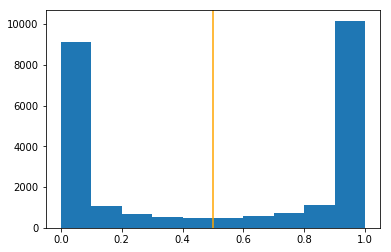

In [19]:
#Plot a Histogram based on the Predictions

plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [20]:
# Calculate the ROC AUC Score

pct_auc = roc_auc_score(y_valid, y_hat) * 100
print('{:0.2f}'.format(pct_auc))

95.24


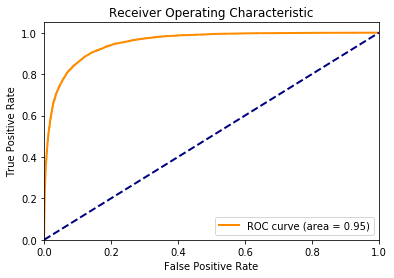

In [25]:
#Plot the Area Under the Curve

fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()